## Setup

In [ ]:
%load_ext rich

In [65]:
import json
import nltk
import rich
from rich import print as rprint
from rich.pretty import pprint
from opensearchpy import OpenSearch


In [ ]:
# Nltk setup
nltk.download("words")
nltk.download("maxent_ne_chunker")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("popular")
nltk.download("tagsets")

### Create opensearch client

In [67]:
host = "localhost"
port = 9200
auth = ("admin", "admin")  # For testing only. Don't store credentials in code.

# Create the client with SSL/TLS enabled, but hostname and certificate verification disabled.
client = OpenSearch(
    hosts=[{"host": host, "port": port}],
    http_compress=True,
    http_auth=auth,
    use_ssl=True,
    verify_certs=False,
    ssl_assert_hostname=False,
    ssl_show_warn=False,
)


### Create test index

In [68]:
index_name = "searchml_week3"

index_body = {
    "settings": {
        "analysis": {
            "filter": {
                "pos_filter": {
                    "type": "pattern_capture",
                    "preserve_original": True,
                    "patterns": ["(.*)#(.*)"],
                }
            },
            "analyzer": {
                "body_pos": {
                    "tokenizer": "whitespace",  # we can't use standard b/c it strips or delimiters
                    "filter": ["pos_filter", "lowercase"],  # put whatever else here
                },
                "body_pos_search": {
                    "tokenizer": "whitespace",  # we can't use standard b/c it strips or delimiters
                    "filter": ["lowercase"],  # put whatever else here
                },
            },
        },
        "index": {"query": {"default_field": "body"}},
    },
    "mappings": {
        "properties": {
            "title": {"type": "text", "analyzer": "english"},
            "body": {"type": "text", "analyzer": "english"},
            "body_sentences": {"type": "text", "analyzer": "english"},
            # Notice the different search analyzer
            "body_pos": {
                "type": "text",
                "analyzer": "body_pos",
                "search_analyzer": "body_pos_search",
            },
            "body_ne": {"type": "text", "analyzer": "standard"},
            "in_stock": {"type": "boolean"},
            "category": {"type": "keyword", "ignore_above": "256"},
            "price": {"type": "float"},
        }
    },
}

try:
    client.indices.delete(index_name)
except:
    pass
client.indices.create(index_name, body=index_body)

# Add our sample document to the index.
docs = [
    {
        "id": "doc_b",
        "title": "Wayne Gretzky",
        "body": "The greatest hockey player of all time is Wayne Gretzky. He holds a record for holding the most records!  Who else even comes close?",
        "price": "15.13",
        "in_stock": True,
        "category": "sports",
    },
    {
        "id": "doc_a",
        "title": "Apple iPhone 13",
        "body": "The all new Apple iPhone 13 has 3 cameras and the fastest chip on the market.  The phone retails for $699 for 64GB of storage.",
        "price": "5.99",
        "in_stock": True,
        "category": "childrens",
    },
    {
        "id": "doc_c",
        "title": "Lead Paint Removal",
        "body": "All lead must be removed from the brown and red paint.  Use the Glidden Lead Paint Killer solvent to keep the paint, but remove the lead!",
        "price": "150.21",
        "in_stock": False,
        "category": "instructional",
    },
    {
        "id": "doc_d",
        "title": "The Three Little Pigs Revisted",
        "price": "3.51",
        "in_stock": True,
        "body": "The big, bad wolf huffed and puffed and blew the house down. The end.  Well, not quite.  It seems the pigs filed an injunction against the wolf and now the wolf has to pay restitution.",
        "category": "childrens",
    },
    {
        "id": "doc_e",
        "title": "Green apples and Spam",
        "price": "2.99",
        "in_stock": True,
        "body": "The little green apple fell from the tree.  It was not a bad apple, so no one could understand why it fell.",
        "category": "childrens",
    },
    {
        "id": "doc_f",
        "title": "Fun with Spans",
        "price": "4.99",
        "in_stock": True,
        "body": "Dan is the President. The United States Government has arrested him.",
        "category": "childrens",
    },
]


## Using nltk

### Exploring nltk tokenizer and pos tagger

Text: Apple's iPhone 13 has 3 cameras and the fastest chip on the market.  The phone retails 
for $699 for 64GB of storage.

Tokens: ['Apple', "'s", 'iPhone', '13', 'has', '3', 'cameras', 'and', 'the', 'fastest', 
'chip', 'on', 'the', 'market', '.', 'The', 'phone', 'retails', 'for', '$', '699', 'for', 
'64GB', 'of', 'storage', '.']

Sentences:
[
    "Apple's iPhone 13 has 3 cameras and the fastest chip on the market.",
    'The phone retails for $699 for 64GB of storage.'
]

POS
[
    ('Apple', 'NNP'),
    ("'s", 'POS'),
    ('iPhone', 'NN'),
    ('13', 'CD'),
    ('has', 'VBZ'),
    ('3', 'CD'),
    ('cameras', 'NNS'),
    ('and', 'CC'),
    ('the', 'DT'),
    ('fastest', 'JJS'),
    ('chip', 'NN'),
    ('on', 'IN'),
    ('the', 'DT'),
    ('market', 'NN'),
    ('.', '.'),
    ('The', 'DT'),
    ('phone', 'NN'),
    ('retails', 'VBZ'),
    ('for', 'IN'),
    ('$', '$'),
    ('699', 'CD'),
    ('for', 'IN'),
    ('64GB', 'CD'),
    ('of', 'IN'),
    ('storage', 'NN'),
    ('.', '.')
]

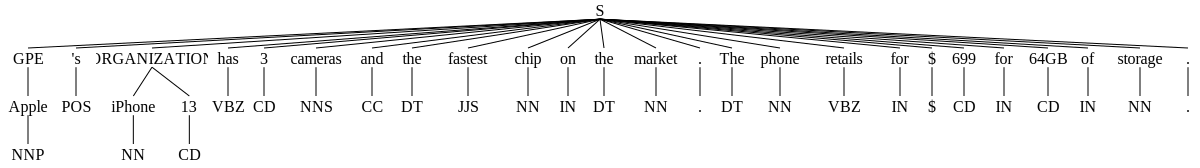

In [69]:
text = "Apple's iPhone 13 has 3 cameras and the fastest chip on the market.  The phone retails for $699 for 64GB of storage."
rprint("Text:", text)

tokens = nltk.word_tokenize(text)
rprint("Tokens:", f"{[t for t in tokens]}")

sentences = nltk.sent_tokenize(text)
rprint("Sentences:", sentences)

pos = nltk.pos_tag(tokens)
rprint("POS", pos)

named_entities = nltk.ne_chunk(pos)
named_entities


In [70]:
tags = set([tag for token, tag in pos])
for tag in tags:
    nltk.help.upenn_tagset(tag)

CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
NN: noun, common, singular or mass
    common-carrier cabbage knuckle-duster Casino afghan shed thermostat
    investment slide humour falloff slick wind hyena override subhumanity
    machinist ...
IN: preposition or conjunction, subordinating
    astride among uppon whether out inside pro despite on by throughout
    below within for towards near behind atop around if like until below
    next into if beside ...
.: sentence terminator
    . ! ?
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
VBZ: verb, present tense, 3rd person singular
    bases reconstructs marks mixes displeases seals carps weaves snatches
    slumps stretches authorizes smolders pictures emerges stockpiles
 

### Indexing annotated docs

In [71]:
def get_entities(named_entities, entity_types):
    result = ""
    for ent in named_entities:  # two cases: we have a NNP or we have a tree
        if isinstance(ent, tuple):
            e_type = ent[1]
            if e_type in entity_types:
                result += ent[0] + " "
        elif isinstance(ent, nltk.Tree):
            if ent.label() in entity_types:
                # these are tuples, we want all of them, but just the first part
                result += "_".join([x[0] for x in ent.leaves()])

    return result


for doc in docs:
    doc_id = doc["id"]
    for item in ["body"]:  # Just do body for now
        value = doc[item]
        tokens = nltk.word_tokenize(value)
        sentences = nltk.sent_tokenize(value)
        pos = nltk.pos_tag(tokens)
        named_entities = nltk.ne_chunk(pos)
        doc["%s_sentences" % item] = " ".join("__SB__ %s __SE__" % x for x in sentences)
        doc["%s_pos" % item] = " ".join(
            ["#".join([x[0], "__%s__" % x[1]]) for x in pos]
        )
        doc["%s_ne" % item] = get_entities(
            named_entities, {"ORGANIZATION", "PERSON", "NNP"}
        )
    print("Indexing {} as: {}".format(doc_id, json.dumps(doc, indent=4)))
    client.index(index=index_name, body=doc, id=doc_id, refresh=True)


Indexing doc_b as: {
    "id": "doc_b",
    "title": "Wayne Gretzky",
    "body": "The greatest hockey player of all time is Wayne Gretzky. He holds a record for holding the most records!  Who else even comes close?",
    "price": "15.13",
    "in_stock": true,
    "category": "sports",
    "body_sentences": "__SB__ The greatest hockey player of all time is Wayne Gretzky. __SE__ __SB__ He holds a record for holding the most records! __SE__ __SB__ Who else even comes close? __SE__",
    "body_pos": "The#__DT__ greatest#__JJS__ hockey#__NN__ player#__NN__ of#__IN__ all#__DT__ time#__NN__ is#__VBZ__ Wayne#__NNP__ Gretzky#__NNP__ .#__.__ He#__PRP__ holds#__VBZ__ a#__DT__ record#__NN__ for#__IN__ holding#__VBG__ the#__DT__ most#__RBS__ records#__NNS__ !#__.__ Who#__WP__ else#__RB__ even#__RB__ comes#__VBZ__ close#__RB__ ?#__.__",
    "body_ne": "Wayne_Gretzky"
}
Indexing doc_a as: {
    "id": "doc_a",
    "title": "Apple iPhone 13",
    "body": "The all new Apple iPhone 13 has 3 cameras and

## Query annotations

In [72]:
# Verify they are in:
print(client.cat.count(index_name, params={"v": "true"}))

epoch      timestamp count
1646145256 14:34:16  6



### Apple as a proper noun

In [73]:
print("Proper Noun Apple")
q = "apple#__NNP__"
query = {"size": 5, "query": {"query_string": {"query": q, "fields": ["body_pos"]}}}
rsp = client.search(body=query, index=index_name)
rsp

Proper Noun Apple


{
    'took': 1,
    'timed_out': False,
    '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
    'hits': {
        'total': {'value': 1, 'relation': 'eq'},
        'max_score': 2.1059992,
        'hits': [
            {
                '_index': 'searchml_week3',
                '_type': '_doc',
                '_id': 'doc_a',
                '_score': 2.1059992,
                '_source': {
                    'id': 'doc_a',
                    'title': 'Apple iPhone 13',
                    'body': 'The all new Apple iPhone 13 has 3 cameras and the fastest chip on the market.  The phone retails for $699 for 64GB of storage.',
                    'price': '5.99',
                    'in_stock': True,
                    'category': 'childrens',
                    'body_sentences': '__SB__ The all new Apple iPhone 13 has 3 cameras and the fastest chip on the market. __SE__ __SB__ The phone retails for $699 for 64GB of storage. __SE__',
                    'body_pos': 'The#__DT__ all#__DT__ new#__JJ__ Apple#__NNP__ iPhone#__NN__ 13#__CD__ has#__VBZ__ 3#__CD__ cameras#__NNS__ and#__CC__ the#__DT__ fastest#__JJS__ chip#__NN__ on#__IN__ the#__DT__ market#__NN__ .#__.__ The#__DT__ phone#__NN__ retails#__VBZ__ for#__IN__ $#__$__ 699#__CD__ for#__IN__ 64GB#__CD__ of#__IN__ storage#__NN__ .#__.__',
                    'body_ne': 'Apple '
                }
            }
        ]
    }
}

### Apple as a common noun

In [74]:
print("Plain ol Apple")
q = "apple#__NN__"
query = {"size": 5, "query": {"query_string": {"query": q, "fields": ["body_pos"]}}}
rsp = client.search(body=query, index=index_name)
rsp

Plain ol Apple


{
    'took': 1,
    'timed_out': False,
    '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
    'hits': {
        'total': {'value': 1, 'relation': 'eq'},
        'max_score': 2.6311197,
        'hits': [
            {
                '_index': 'searchml_week3',
                '_type': '_doc',
                '_id': 'doc_e',
                '_score': 2.6311197,
                '_source': {
                    'id': 'doc_e',
                    'title': 'Green apples and Spam',
                    'price': '2.99',
                    'in_stock': True,
                    'body': 'The little green apple fell from the tree.  It was not a bad apple, so no one could understand why it fell.',
                    'category': 'childrens',
                    'body_sentences': '__SB__ The little green apple fell from the tree. __SE__ __SB__ It was not a bad apple, so no one could understand why it fell. __SE__',
                    'body_pos': 'The#__DT__ little#__JJ__ green#__JJ__ apple#__NN__ fell#__VBD__ from#__IN__ the#__DT__ tree#__NN__ .#__.__ It#__PRP__ was#__VBD__ not#__RB__ a#__DT__ bad#__JJ__ apple#__NN__ ,#__,__ so#__IN__ no#__DT__ one#__NN__ could#__MD__ understand#__VB__ why#__WRB__ it#__PRP__ fell#__VBD__ .#__.__',
                    'body_ne': ''
                }
            }
        ]
    }
}

### Use span query
 - [span_within](https://www.elastic.co/guide/en/elasticsearch/reference/7.10/query-dsl-span-within-query.html)
 - [span_near](https://www.elastic.co/guide/en/elasticsearch/reference/7.10/query-dsl-span-near-query.html)

In [75]:

# Sentence query.  going to use a new type of query called a SpanQuery
q = "President United States"  # should return one match
query = {"size": 5, "query": {"query_string": {"query": q, "fields": ["body_pos"]}}}
rsp = client.search(body=query, index=index_name)
rich.print(rsp)

# Should return no match
query = {
    "size": 5,
    "query": {
        "span_within": {
            "little": {
                "span_near": {
                    "clauses": [
                        {"span_term": {"body_sentences": "President"}},
                        {"span_term": {"body_sentences": "United"}},
                        {"span_term": {"body_sentences": "States"}},
                    ]
                }
            },
            "big": {
                "span_near": {
                    "clauses": [
                        {"span_term": {"body_sentences": "__SB__"}},
                        {"span_term": {"body_sentences": "__SE__"}},
                    ]
                }
            },
        }
    },
}

rsp = client.search(body=query, index=index_name)
rich.print(rsp)

{
    'took': 1,
    'timed_out': False,
    '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
    'hits': {
        'total': {'value': 1, 'relation': 'eq'},
        'max_score': 7.04297,
        'hits': [
            {
                '_index': 'searchml_week3',
                '_type': '_doc',
                '_id': 'doc_f',
                '_score': 7.04297,
                '_source': {
                    'id': 'doc_f',
                    'title': 'Fun with Spans',
                    'price': '4.99',
                    'in_stock': True,
                    'body': 'Dan is the President. The United States Government has arrested 
him.',
                    'category': 'childrens',
                    'body_sentences': '__SB__ Dan is the President. __SE__ __SB__ The United 
States Government has arrested him. __SE__',
                    'body_pos': 'Dan#__NNP__ is#__VBZ__ the#__DT__ President#__NNP__ .#__.__ 
The#__DT__ United#__NNP__ States#__NNPS__ Government#__NNP__ has#__VBZ__ arrested#__VBN__ 
him#__PRP__ .#__.__',
                    'body_ne': 'President Government '
                }
            }
        ]
    }
}

{
    'took': 0,
    'timed_out': False,
    '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
    'hits': {'total': {'value': 0, 'relation': 'eq'}, 'max_score': None, 'hits': []}
}